<a href="https://colab.research.google.com/github/ChloeH88/JSC270_HW2_2022_CHuang/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Libraries you'll likely need

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


###Importing data

In [2]:
income94 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)
income94.columns = ['age','workclass', 'fnlwgt','education','education_num','marital_status','occupation',
                    'relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','gross_income_group']

#Part 2: Data Analysis


##2.1 Initial Data Exploration



###Q1: Check the columns
Are they the expected data types based on their descriptions in [this text file description of the data?](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names)

In [3]:
income94.info()
# Answer: all columns are expected data types, 
# as all continuous attributes are int64 and the categorical ones are object.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   age                 32561 non-null  int64 
 1   workclass           32561 non-null  object
 2   fnlwgt              32561 non-null  int64 
 3   education           32561 non-null  object
 4   education_num       32561 non-null  int64 
 5   marital_status      32561 non-null  object
 6   occupation          32561 non-null  object
 7   relationship        32561 non-null  object
 8   race                32561 non-null  object
 9   sex                 32561 non-null  object
 10  capital_gain        32561 non-null  int64 
 11  capital_loss        32561 non-null  int64 
 12  hours_per_week      32561 non-null  int64 
 13  native_country      32561 non-null  object
 14  gross_income_group  32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


###Q2: Missing values
How are missing values represented in this data? Cast missing values to np.nan, if necessary. Count the number of missing values in each column.

In [4]:
print(income94['occupation'].value_counts())
print(income94['workclass'].value_counts())
# Answer: missing values are in categorical variables, and are represented by ' ?'

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: occupation, dtype: int64
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64


In [5]:
# replace missing values with np.nan
income94 = income94.replace(to_replace = ' ?', value = np.nan)

In [6]:
# count missing values:
missing_cols = ['workclass', 'occupation']
for col in missing_cols:
  print(f"Number of missing values for {col}:", income94[col].isnull().sum())

Number of missing values for workclass: 1836
Number of missing values for occupation: 1843


###Q3: capital_gain and capital_loss
Individually plot the distributions of capital_gain and capital_loss. Do you think these variables should be transformed to categorical variables? Why or why not? If yes, create a new variable(s) with your suggested transformation and plot or describe in a table the distribution of the new categorical variable(s).

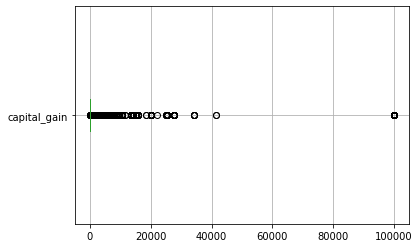

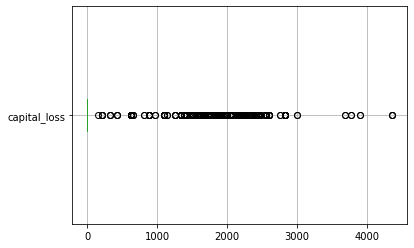

In [7]:
capitals = ['capital_gain', 'capital_loss']
for col in capitals:
    income94[capitals].boxplot([col], vert=False)
    plt.show()

**Tranform into categorical variables:**

I think we can convert these two variables into categorical ones, 
because approximately 50% of the values are 0, so I decided to have 2 categories: 0 and not 0. 

Also, after dividing them up into categories/labels, 
we can see more clearly how many counts are in each group. 
And making conclusions based on categories(has capital gain/ no capital gain group)
makes the data more understandable to audiences.

But, there are definitely some drawbacks, like 
we lose some precision by ignoring the distinction between different numeric values (e.g. 100000 and 10000 capital_gain), and cannot apply numerical statistical methods on them.

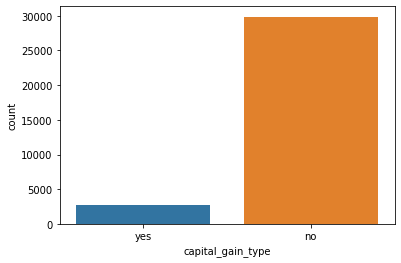

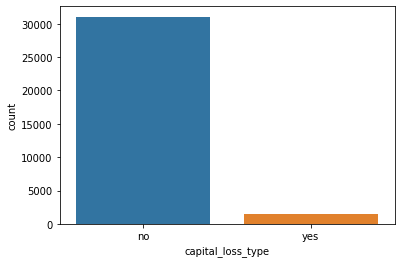

In [8]:
# Divide capital gain and loss into 2 categories based on whether it equals 0 or not
income94['capital_gain_type'] = np.where(income94['capital_gain']==0, 'no', 'yes')
income94['capital_loss_type'] = np.where(income94['capital_loss']==0, 'no', 'yes')

# Plot
sns.countplot(x=income94['capital_gain_type'])
plt.show()

sns.countplot(x=income94['capital_loss_type'])
plt.show()

###Q4: Sampling weights fnlwgt
Plot or numerically explore the distribution of fnlwgt. Is the variable symmetrically distributed? Compare the distribution of this variable between men and women and comment on any trends you notice. Should outliers be excluded? If you think yes, set the fnlwgt values for those you deem to be outliers as missing for the remainder of your analyses.

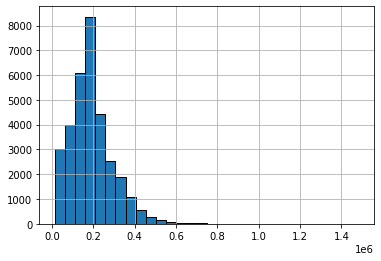

In [9]:
# Plot
income94['fnlwgt'].hist(bins=30, edgecolor="black")
plt.show()
# fnlwgt is not symmetrically distributed; it's right skewed

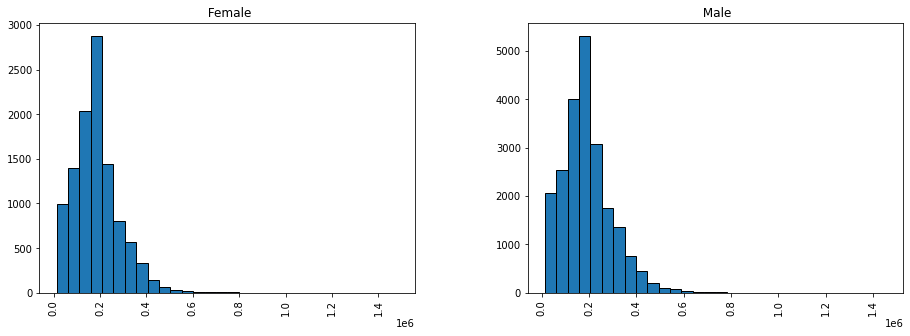

In [10]:
# compare between men and women
income94['fnlwgt'].hist(by=income94.sex, figsize=(15,5), bins=30, edgecolor="black")
plt.show()

**Compare distribution:**

The shape of distribution between men and women are quite similar, and the median and mode are also similar.
However, noticing the y-axis, men's weight is approximately 1.5 times higher than women's.

**Outliers:**

I do think outliers needed to be included, because weight is artificially assigned to help us decide if two people have similar demographic characteristics.

##2.2 Correlation (age, education_num, and hours_per_week)


###(a) Do any of the variables appear to be correlated? How did you make your assessment?

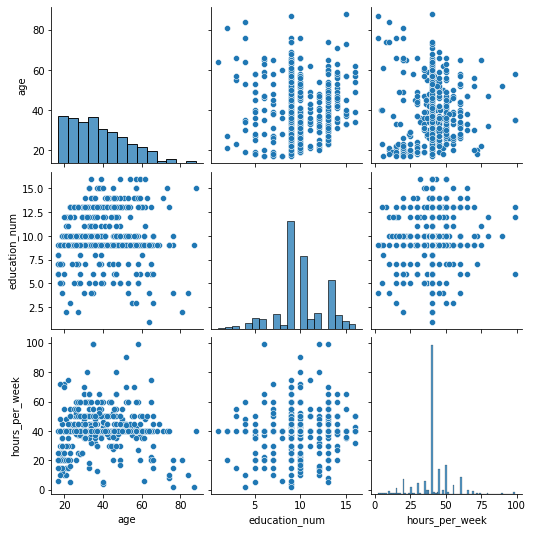

In [11]:
# Select the targeted columns
vars = ['age', 'education_num', 'hours_per_week', 'sex']
cor_dataset = income94[vars]

# Use a subset of the big dataset to plot pairwise scatter plot, to have a general idea about the coorelation
sub = cor_dataset.sample(500)
sns.pairplot(data=sub)
plt.show()

In [12]:
# Then, use a pairwise correlation matrix to find a more precise correlation
corr = cor_dataset.corr()
corr

,age,education_num,hours_per_week
age,1.000000,0.036527,0.068756
education_num,0.036527,1.000000,0.148123
hours_per_week,0.068756,0.148123,1.000000


**Answer**:

From the pairwise scatter plot, correlation matrix, since **education_num and hours_per_week** have correlation coefficient as 0.148, they seem to have a **very weak positive correlation.**

###(b) Test correlation
Statistically test any variable pairs with a correlation coefficient > |0.1| for its difference from 0 and report your result. Is the direction and significance of yourfinding as expected?

In [13]:
stat, p = stats.pearsonr(cor_dataset['education_num'], cor_dataset['hours_per_week'])
print('stat=%.3f, p=%.3f' % (stat, p))

stat=0.148, p=0.000


**Answer**

From the Pearson correlation test, we know the correlation coefficient (0.148) shows there is a very weak positive correlation. While the extremely low p-value confirms the fact that there is indeed a linear correlation between education_num and hours_per_week.

###(c) Correlation (age and education_num)
How does the correlation (and its significance) between education_num and age compare between male and female participants? Is this expected?


In [14]:
for val in income94['sex'].unique():
  cor_sex = cor_dataset[cor_dataset.sex == val]
  stat, p = stats.pearsonr(cor_sex['education_num'], cor_sex['age'])
  print(f'{val}: stat=%.3f, p=%.3f' % (stat, p))

 Male: stat=0.060, p=0.000
 Female: stat=-0.018, p=0.063


**Answer:**

From the coefficients: for man, as age goes up, education_num increases, whereas for women, education_num decreases as age goes up. 

However, if we set the significance level at 5%, the 0.063 p-value for women leads to the conclusion that there may be no correlation between education_num and age for women. While the very low p-value for men shows there may be some association between education_num and age for them.

The result is sort of expected. For men, they may have more money to pursue their academic path as their age increases. Yet, for women, it really depends on their socioclass, financial situation and many other social/cultural factors. Those factors may push women to take care of their home/child instead of persuing education. Because of diverse social/cultural difference, we can hardly conclude association between women's age and education_num.

###(d) Covariance matrix
Compute the covariance matrix for education_num and hours_per_week. What
conclusions can you draw from the covariance matrix?

In [15]:
cov = ['education_num', 'hours_per_week']
cov_data = income94[cov]

cov_data.cov()

,education_num,hours_per_week
education_num,6.618890,4.705338
hours_per_week,4.705338,152.458995


**Answer:**

Positive covariance indicates the direction of relationship between varialbes, thus education_num and hours_per_week are positively correlated. But covariance doesn't give us the strength of the correlation, and it doesn't account for difference in unit between variables.

##2.3 Regression
Fit a linear regression with hours_per_week as the dependent variable and sex as the independent variable.


###(a) Do men tend to work more hours?

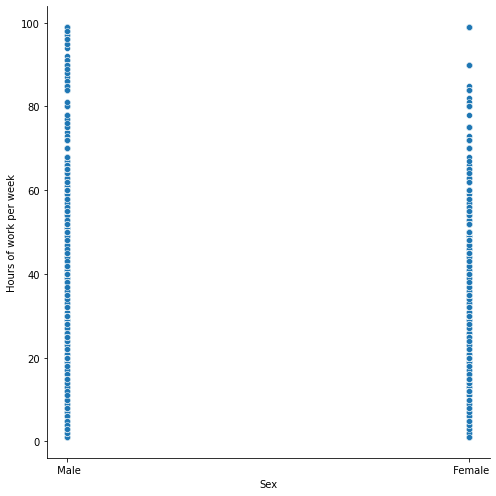

In [16]:
# plot hours_per_week versus sex
g = sns.relplot(x="sex",
                y="hours_per_week",
                height=7,
                data=income94)
g.set_xlabels('Sex')
g.set_ylabels('Hours of work per week')
plt.show()

In [17]:
# Fit a model
reg1 = smf.ols('hours_per_week ~ sex', data = income94).fit()
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:         hours_per_week   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1807.
Date:                Mon, 14 Feb 2022   Prob (F-statistic):               0.00
Time:                        07:50:54   Log-Likelihood:            -1.2716e+05
No. Observations:               32561   AIC:                         2.543e+05
Df Residuals:                   32559   BIC:                         2.543e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       36.4104      0.116    314.412   

**Answer**

Yes, because the coefficient for sex (6.02) represents the estimated average difference in hours_per_week between men and women. And since 'Male' is the non-baseline variable, Male = 1 and women = 0. Thus, hours_per_week for men - estimated hours_per_week for women = 6.02 > 0, meaning men tend to work more hours.

And since p-value is very low (approaching 0), this coefficient is statistically significant.

###(b) Add a control variable
Add education_num as a control variable, does the trend in hours worked by men
vs women remain the same? Is the coefficient for education_num statistically
significant? What is the 95% confidence interval?

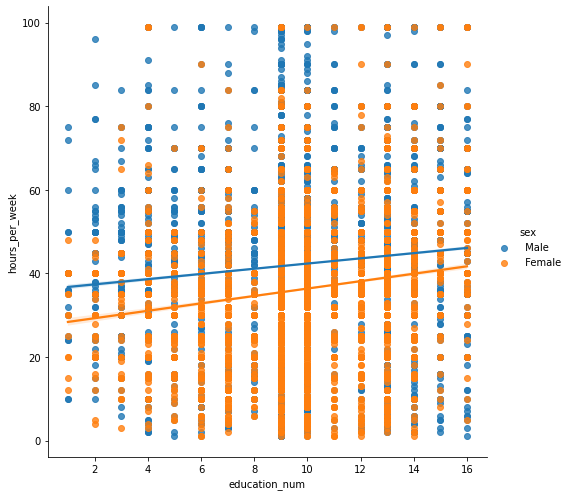

In [18]:
sns.lmplot(x="education_num",
           y="hours_per_week",
           hue="sex",
           height=7,
           data=income94)
plt.show()

In [19]:
reg2 = smf.ols('hours_per_week ~ education_num + sex', data = income94).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:         hours_per_week   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     1295.
Date:                Mon, 14 Feb 2022   Prob (F-statistic):               0.00
Time:                        07:51:01   Log-Likelihood:            -1.2680e+05
No. Observations:               32561   AIC:                         2.536e+05
Df Residuals:                   32558   BIC:                         2.536e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        29.4106      0.281    104.556

**Answer:**

(1) Trend remains the same (men works more hours than women), since the coefficient for sex is 5.97 > 0.

(2) The coefficient for education_num is statistically significant as its p-value is extremely small.

(3) The 95% confidence interval for the coefficient for education_num is (0.647, 0.748) 

###(c) Add gross_income_group
Now add gross_income_group as a binary variable in the model and compare
this model with the models including (i) only sex and (ii) sex and education_num. Write down the interpretation for the coefficient for sex in each model. What statistic(s) can help to decide which model is the “best”? How do the three models compare?

In [20]:
reg3 = smf.ols('hours_per_week ~ education_num + sex + gross_income_group', data = income94).fit()
print(reg3.summary())

                            OLS Regression Results                            
Dep. Variable:         hours_per_week   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     1130.
Date:                Mon, 14 Feb 2022   Prob (F-statistic):               0.00
Time:                        07:51:02   Log-Likelihood:            -1.2643e+05
No. Observations:               32561   AIC:                         2.529e+05
Df Residuals:                   32557   BIC:                         2.529e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

**Answer(1):**

(1) Interpretation of coefficient for sex:

*   (i) only sex: the estimated average difference in hours_per_week between men and women, i.e. men's hours_per_week **-** women's hours_per_week = 6.02.

*   (ii) sex and education_num: the estimated average difference between men's hours_per_week and women's (actually men's - women's) is 5.97, when education_num = 0

*   (ii) sex + education_num + gross_income_group: the estimated average difference between men's hours_per_week and women's (actually men's - women's) is 5.1, when education_num = 0 and gross_income_group <= 50k.

**Answer(2) and (3):**

(2) What statistics help understsand which model is the best?

R squared, RSE, and RMSE can all help determine which model is the best (see the next chunk of code for RSE and RMSE).

(3) How do models compare?

As we see that RSE and RMSE for model 3(model with sex + education_num + gross_income_group) is the smallest, meaning model 3 is the best model interms of accurately predicting the response variable. And its R-squared is the largest from the OLS regression results above, indicating this linear regression model fits the observed data the best. Hence, I argue that model 3 is the best.

In [21]:
# check each model's RSE and RMSE
models = [reg1, reg2, reg3]
for i in range(len(models)):
  rse = np.sqrt(models[i].mse_resid)
  rmse = rse*np.sqrt((income94.shape[0]-2)/income94.shape[0])
  print(f"Model {i}'s RSE:", rse)
  print(f"Model {i}'s RMSE:", rmse)

Model 0's RSE: 12.01859925019377
Model 0's RMSE: 12.018230134263332
Model 1's RSE: 11.88408396927768
Model 1's RMSE: 11.8837189845885
Model 2's RSE: 11.751216518537175
Model 2's RMSE: 11.750855614480994


#Part 3: My own regression analysis
The relationship between hours_per_week and (education_num and relationship (especially wife & husband))

In [22]:
# select only wife and husband
income94_sub = income94[
                        (income94.relationship == ' Wife') | (income94.relationship == ' Husband')
                        ]

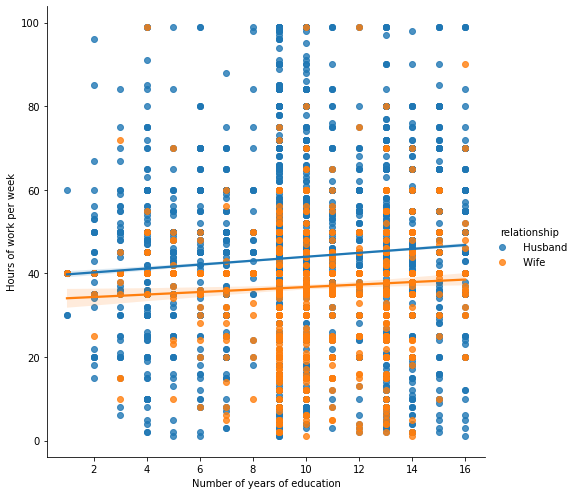

In [23]:
# Plot
g = sns.lmplot(x="education_num",
                y="hours_per_week",
                hue='relationship',
                height=7,
                data=income94_sub)
g.set_xlabels('Number of years of education')
g.set_ylabels('Hours of work per week')
plt.show()

In [24]:
# center the covariate since education_num = 0 makes no sense
income94_sub['education_num_centered'] = income94_sub['education_num'] - income94_sub['education_num'].mean()
print("Mean of education_num: ", income94_sub['education_num'].mean())

# Fit the model              
my_reg = smf.ols('hours_per_week ~ education_num_centered + relationship', data = income94_sub).fit()
print(my_reg.summary())


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Mean of education_num:  10.34096605921008
                            OLS Regression Results                            
Dep. Variable:         hours_per_week   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     355.4
Date:                Mon, 14 Feb 2022   Prob (F-statistic):          1.73e-151
Time:                        07:51:07   Log-Likelihood:                -57152.
No. Observations:               14761   AIC:                         1.143e+05
Df Residuals:                   14758   BIC:                         1.143e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [25]:
# Calculate RSE and RMSE of my model
rse = np.sqrt(my_reg.mse_resid)
rmse = rse*np.sqrt((income94_sub.shape[0]-2)/income94_sub.shape[0])

print("RSE:", rse)
print("RMSE:", rmse)

RSE: 11.622792388254636
RMSE: 11.62200496286921
